In [28]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# @title Figure settings
import ipywidgets as widgets  # interactive display
from ipywidgets import fixed
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [30]:
# @title Plotting functions
import numpy
from numpy.linalg import inv, eig
from math import ceil
from matplotlib import pyplot, ticker, get_backend, rc
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle

_int_backends = ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg',
                 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo',
                 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
_backend = get_backend()   # get current backend name

# shrink figsize and fontsize when using %matplotlib notebook
if _backend in _int_backends:
  fontsize = 4
  fig_scale = 0.75
else:
  fontsize = 5
  fig_scale = 1

grey = '#808080'
gold = '#cab18c'        # x-axis grid
lightblue = '#0096d6'   # y-axis grid
green = '#008367'       # x-axis basis vector
red = '#E31937'         # y-axis basis vector
darkblue = '#004065'

pink, yellow, orange, purple, brown = '#ef7b9d', '#fbd349', '#ffa500', '#a35cff', '#731d1d'

quiver_params = {'angles': 'xy',
                 'scale_units': 'xy',
                 'scale': 1,
                 'width': 0.012}

grid_params = {'linewidth': 0.5,
               'alpha': 0.8}

def set_rc(func):
  def wrapper(*args, **kwargs):
    rc('font', family='serif', size=fontsize)
    rc('figure', dpi=200)
    rc('axes', axisbelow=True, titlesize=5)
    rc('lines', linewidth=1)
    func(*args, **kwargs)
  return wrapper

@set_rc
def plot_vector(vectors, tails=None):
  ''' Draw 2d vectors based on the values of the vectors and the position of their tails.

  Parameters
  ----------
  vectors : list.
    List of 2-element array-like structures, each represents a 2d vector.

  tails : list, optional.
    List of 2-element array-like structures, each represents the coordinates of the tail
    of the corresponding vector in vectors. If None (default), all tails are set at the
    origin (0,0). If len(tails) is 1, all tails are set at the same position. Otherwise,
    vectors and tails must have the same length.

  Examples
  --------
  >>> v = [(1, 3), (3, 3), (4, 6)]
  >>> plot_vector(v)      # draw 3 vectors with their tails at origin
  >>> t = [numpy.array((2, 2))]
  >>> plot_vector(v, t)   # draw 3 vectors with their tails at (2,2)
  >>> t = [[3, 2], [-1, -2], [3, 5]]
  >>> plot_vector(v, t)   # draw 3 vectors with 3 different tails

  '''
  vectors = numpy.array(vectors)
  assert vectors.shape[1] == 2, "Each vector should have 2 elements."
  if tails is not None:
    tails = numpy.array(tails)
    assert tails.shape[1] == 2, "Each tail should have 2 elements."
  else:
    tails = numpy.zeros_like(vectors)

  # tile vectors or tails array if needed
  nvectors = vectors.shape[0]
  ntails = tails.shape[0]
  if nvectors == 1 and ntails > 1:
    vectors = numpy.tile(vectors, (ntails, 1))
  elif ntails == 1 and nvectors > 1:
    tails = numpy.tile(tails, (nvectors, 1))
  else:
    assert tails.shape == vectors.shape, "vectors and tail must have a same shape"

  # calculate xlimit & ylimit
  heads = tails + vectors
  limit = numpy.max(numpy.abs(numpy.hstack((tails, heads))))
  limit = numpy.ceil(limit * 1.2)   # add some margins

  figsize = numpy.array([2,2]) * fig_scale
  figure, axis = pyplot.subplots(figsize=figsize)
  axis.quiver(tails[:,0], tails[:,1], vectors[:,0], vectors[:,1], color=darkblue,
                  angles='xy', scale_units='xy', scale=1)
  axis.set_xlim([-limit, limit])
  axis.set_ylim([-limit, limit])
  axis.set_aspect('equal')

  # if xticks and yticks of grid do not match, choose the finer one
  xticks = axis.get_xticks()
  yticks = axis.get_yticks()
  dx = xticks[1] - xticks[0]
  dy = yticks[1] - yticks[0]
  base = max(int(min(dx, dy)), 1)   # grid interval is always an integer
  loc = ticker.MultipleLocator(base=base)
  axis.xaxis.set_major_locator(loc)
  axis.yaxis.set_major_locator(loc)
  axis.grid(True, **grid_params)

  # show x-y axis in the center, hide frames
  axis.spines['left'].set_position('center')
  axis.spines['bottom'].set_position('center')
  axis.spines['right'].set_color('none')
  axis.spines['top'].set_color('none')

@set_rc
def plot_transformation_helper(axis, matrix, *vectors, unit_vector=True, unit_circle=False, title=None):
  """ A helper function to plot the linear transformation defined by a 2x2 matrix.

  Parameters
  ----------
  axis : class matplotlib.axes.Axes.
    The axes to plot on.

  matrix : class numpy.ndarray.
    The 2x2 matrix to visualize.

  *vectors : class numpy.ndarray.
    The vector(s) to plot along with the linear transformation. Each array denotes a vector's
    coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.

  unit_vector : bool, optional.
    Whether to plot unit vectors of the standard basis, default to True.

  unit_circle: bool, optional.
    Whether to plot unit circle, default to False.

  title: str, optional.
    Title of the plot.

  """
  assert matrix.shape == (2,2), "the input matrix must have a shape of (2,2)"
  grid_range = 20
  x = numpy.arange(-grid_range, grid_range+1)
  X_, Y_ = numpy.meshgrid(x,x)
  I = matrix[:,0]
  J = matrix[:,1]
  X = I[0]*X_ + J[0]*Y_
  Y = I[1]*X_ + J[1]*Y_
  origin = numpy.zeros(1)

  # draw grid lines
  for i in range(x.size):
    axis.plot(X[i,:], Y[i,:], c=gold, **grid_params)
    axis.plot(X[:,i], Y[:,i], c=lightblue, **grid_params)

  # draw (transformed) unit vectors
  if unit_vector:
    axis.quiver(origin, origin, [I[0]], [I[1]], color=green, **quiver_params)
    axis.quiver(origin, origin, [J[0]], [J[1]], color=red, **quiver_params)

  # draw optional vectors
  color_cycle = cycle([pink, darkblue, orange, purple, brown])
  if vectors:
    for vector in vectors:
      color = next(color_cycle)
      vector_ = matrix @ vector.reshape(-1,1)
      axis.quiver(origin, origin, [vector_[0]], [vector_[1]], color=color, **quiver_params)

  # draw optional unit circle
  if unit_circle:
    alpha =  numpy.linspace(0, 2*numpy.pi, 41)
    circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
    circle_trans = matrix @ circle
    axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

  # hide frames, set xlimit & ylimit, set title
  limit = 4
  axis.spines['left'].set_position('center')
  axis.spines['bottom'].set_position('center')
  axis.spines['left'].set_linewidth(0.3)
  axis.spines['bottom'].set_linewidth(0.3)
  axis.spines['right'].set_color('none')
  axis.spines['top'].set_color('none')
  axis.set_xlim([-limit, limit])
  axis.set_ylim([-limit, limit])
  if title is not None:
    axis.set_title(title)

@set_rc
def plot_linear_transformation(matrix, *vectors, name = None, unit_vector=True, unit_circle=False):
  """ Plot the linear transformation defined by a 2x2 matrix using the helper
  function plot_transformation_helper(). It will create 2 subplots to visualize some
  vectors before and after the transformation.

  Parameters
  ----------
  matrix : class numpy.ndarray.
    The 2x2 matrix to visualize.

  *vectors : class numpy.ndarray.
    The vector(s) to plot along with the linear transformation. Each array denotes a vector's
    coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.

  unit_vector : bool, optional.
    Whether to plot unit vectors of the standard basis, default to True.

  unit_circle: bool, optional.
    Whether to plot unit circle, default to False.

  """
  figsize = numpy.array([4,2]) * fig_scale
  figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
  plot_transformation_helper(axis1, numpy.identity(2), *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='Before transformation')
  plot_transformation_helper(axis2, matrix, *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='After transformation')
  if name is not None:
    figure.suptitle(f'Population {name}')


def plot_eig_vec_transform(W):
  classic = 'k'
  vec_names = ['a', 'b','c','d','e','f','g', 'h']

  _, vecs = np.linalg.eig(W)
  vecs = vecs.T

  fig, axes = plt.subplots(1, 2, figsize=(2, 1))
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

  for i in range(2):
    axes[i].set(xlim=[-3.5, 3.5], ylim=[-3.5,3.5])
    axes[i].axis('Off')
    axes[i].plot([0, 0], [-3.5, 3.5], classic, alpha=.4)
    axes[i].plot([-3.5, 3.5], [0, 0], classic, alpha=.4)

  for i_vec, vec in enumerate(vecs):
    axes[0].arrow(0, 0, vec[0], vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
    axes[0].annotate(vec_names[i_vec], xy=(vec[0]+np.sign(vec[0])*.15, vec[1]+np.sign(vec[1])*.15), color=colors[i_vec])

    transformed_vec = np.matmul(W, vec)
    axes[1].arrow(0, 0, transformed_vec[0], transformed_vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
    axes[1].annotate(vec_names[i_vec], xy=(transformed_vec[0]+np.sign(transformed_vec[0])*.15, transformed_vec[1]+np.sign(transformed_vec[1])*.15), color=colors[i_vec])

  axes[0].set_title('Before')
  axes[1].set_title('After')

### Coding Exercise 1.1: Understanding neural transformations

We will look at a group of 2 LGN neurons which get input from 2 retinal neurons: we will call the population of LGN neurons population $p$. Below, we have the system of linear equations that dictates the neuron models for each population. $r_1$ and $r_2$ correspond to the retinal neural activities (of neuron 1 and 2). $g_{p_1}$ and  $g_{p_2}$ correspond to the responses of the LGN neurons 1 and 2 in population $p$. 

\begin{align}
r_1 + 3r_2 &= g_{p_1} \\
2r_1 + r_2 &= g_{p_2}
\end{align}

<br>

1) Cast each equation (i.e., $g_{p_1}$ and $g_{p_2}$) as a matrix-vector multiplication: 

\begin{equation}
\mathbf{g}_p = \mathbf{P}\mathbf{r}
\end{equation}

where $P$ is the weight matrix to population $p$. 

2) Let's say we only recorded from the LGN cells (and know the weight matrix) and are trying to figure out how the retinal cells responded. Solve the matrix equation for the given LGN activities:

\begin{equation}
\mathbf{g}_p = 
\begin{bmatrix}
16 \\
7
\end{bmatrix}
\end{equation}

In [38]:
# Create p (using np array)
P = np.array([[1,3],[2,1]])

# Create g_p (using np array)
g_p = np.array([16,7])

# Solve for r (using np.linalg.inv)
r = np.linalg.inv(P) @ g_p

# Print r
print (r)

[1. 5.]


### Coding Exercise 1.2: Creating matrices for transformations

Come up with a matrix $A$ for which the corresponding linear transformation is reflection through the $y$ axis (flipping across the $y$ axis). For example, $\mathbf{x} = \begin{bmatrix}
2 \\
6  \\
\end{bmatrix}$ should become $\mathbf{b} = \begin{bmatrix}
-2 \\
6  \\
\end{bmatrix}$ when multiplied with $A$. 


**Remember to think about where your basis vectors should end up! Then your matrix consists of the transformed basis vectors. Drawing out what you want to happen can help**

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


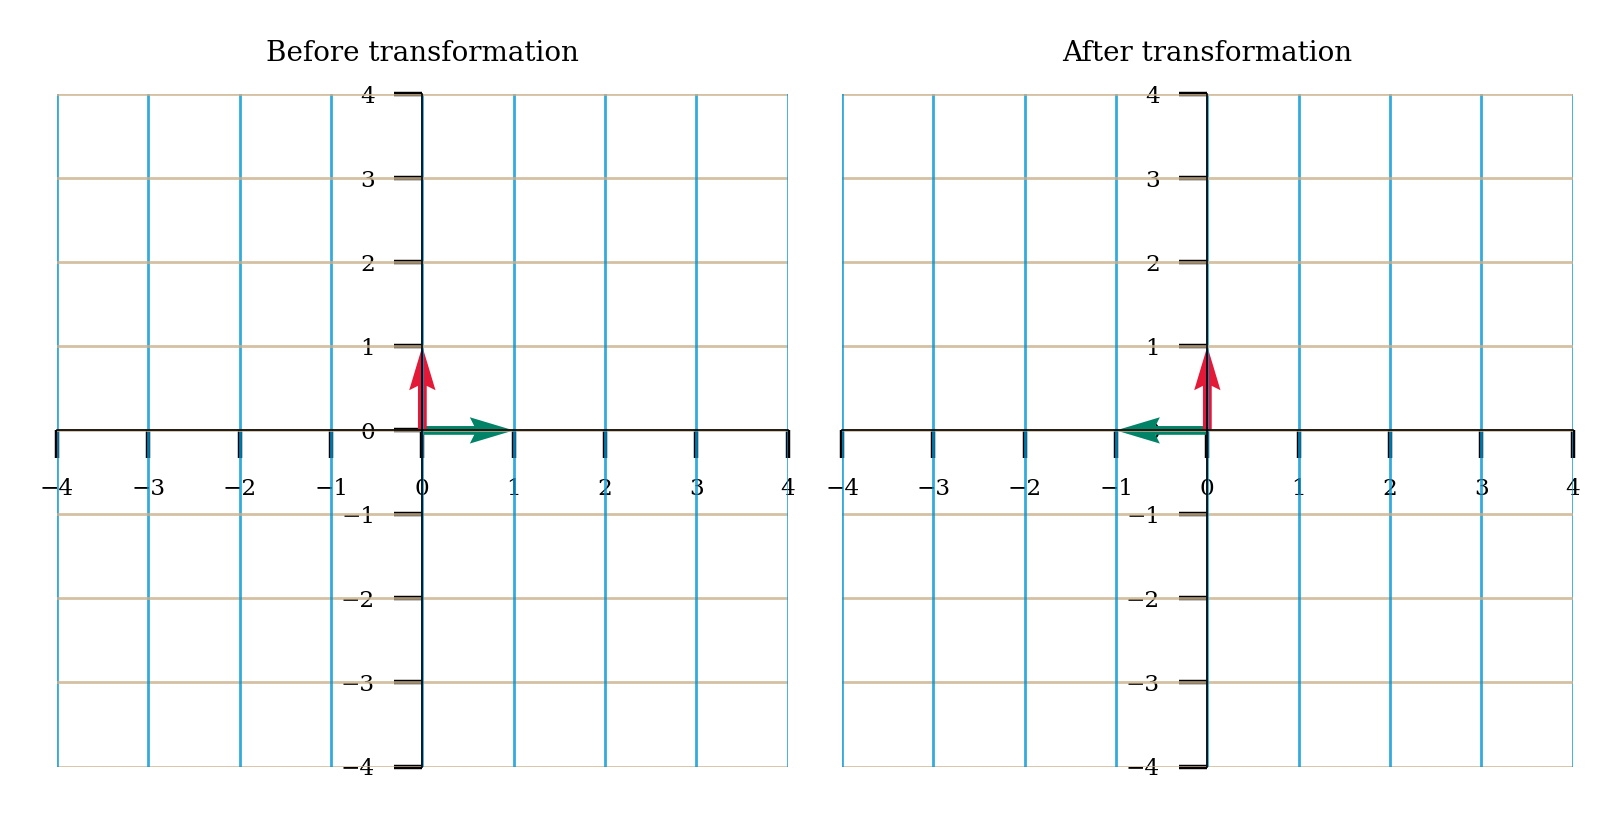

In [32]:
A = np.array([[-1,0],[0,1]])

# Visualize transformation
plot_linear_transformation(A)

Come up with a matrix $A$ for which the corresponding linear transformation is projecting onto the $x$ axis. For example, $\bar{x} = \begin{bmatrix}
2 \\
3  \\
\end{bmatrix}$ should become $\bar{b} = \begin{bmatrix}
2 \\
0  \\
\end{bmatrix}$ when multiplied with $A$. 

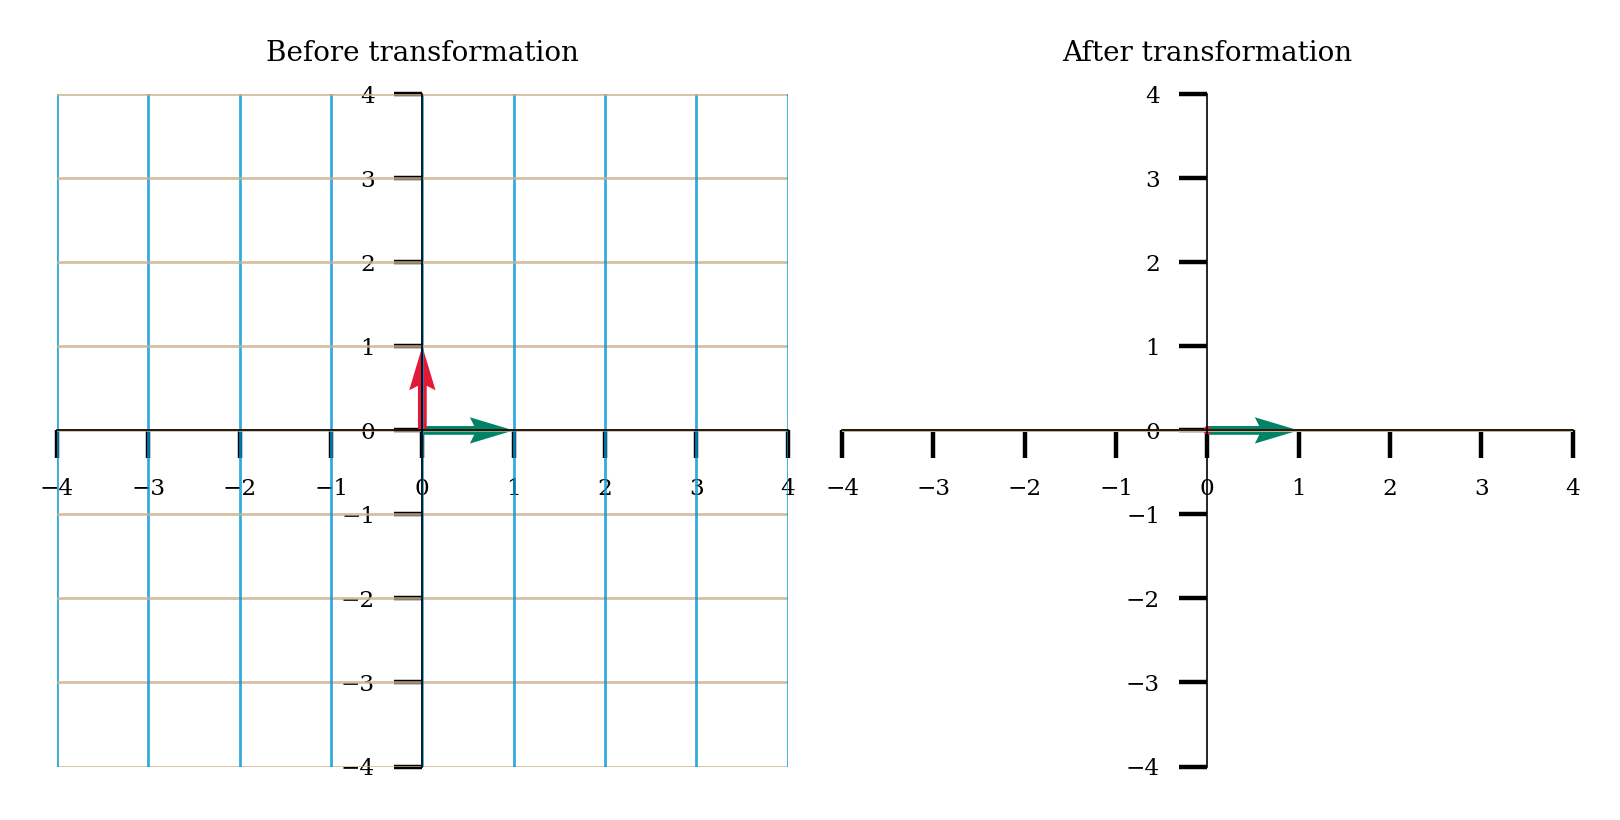

In [39]:
A = np.array([[1,0],[0,0]])

# Uncomment to visualize transformation
plot_linear_transformation(A)